In [5]:
import pandas as pd

trained = pd.read_csv('training.csv')

trained.head()


,target,id,date,flag,user,tweets
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [8]:
trained.shape

(83559, 6)

In [25]:
trained1 = trained.drop(['flag'], axis=1)
trained1.head()

,target,id,date,user,tweets
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


In [19]:
trained1['target'].value_counts()

0    83559
Name: target, dtype: int64

In [26]:
import numpy as np

totalTweets = 83559
trainIndex, testIndex = list(), list()
for i in range(trained1.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = trained1.iloc[trainIndex]
testData = trained1.iloc[testIndex]
trained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83559 entries, 0 to 83558
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  83559 non-null  int64 
 1   id      83559 non-null  int64 
 2   date    83559 non-null  object
 3   flag    83558 non-null  object
 4   user    83558 non-null  object
 5   tweets  83558 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.8+ MB


In [27]:
trainData.head()

,target,id,date,user,tweets
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


In [28]:
trainData['target'].value_counts()

0    81900
Name: target, dtype: int64

In [29]:
testData['target'].value_counts()

0    1659
Name: target, dtype: int64

In [30]:
testData.head()

,target,id,date,user,tweets
51,0,1467821085,Mon Apr 06 22:22:26 PDT 2009,crzy_cdn_bulas,our duck and chicken are taking wayyy too long...
114,0,1467839007,Mon Apr 06 22:27:08 PDT 2009,eyezup,@mercedesashley Damn! The grind is inspiration...
135,0,1467842568,Mon Apr 06 22:28:07 PDT 2009,josiahmcdermott,i miss kenny powers
136,0,1467842607,Mon Apr 06 22:28:09 PDT 2009,VanessaSingline,@BridgetsBeaches Thank you for letting people ...
180,0,1467857722,Mon Apr 06 22:32:02 PDT 2009,blackheartbunny,Check out my mug http://www.erika-obscura.blo...


In [38]:
import nltk
from nltk import punkt
import matplotlib.pyplot as plt

from wordcloud import WordCloud
counts = trained['tweets'].value_counts()

counts.index = counts.index.astype(str)



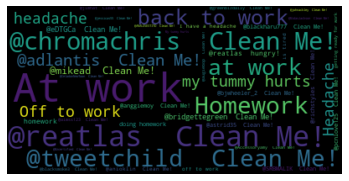

In [39]:
# depressive_words = ' '.join(str(trained1[trained1['target'] == 0]['tweets']))
# depressive_wc = WordCloud(width=512, height=512, collocations=False, colormap="Blues").generate(depressive_words)
# plt.figure(figsize=(10, 8), facecolor='k')
# plt.imshow(depressive_wc)
# plt.axis('off')
# plt.tight_layout(pad=1)
# plt.show()

wordcloud = WordCloud().generate_from_frequencies(counts)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [40]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def process_message(tweets, lower_case=True, stem=True, stop_words=True, gram=2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(tweets)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return words


In [41]:

class TweetClassifier(object):
    def __init__(self, trainData, method='tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                           len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                       len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets

    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list()
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log(
                (self.depressive_tweets + self.positive_tweets) \
                / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (
                        self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))

        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                                      / (self.idf_depressive.get(word, 0) +
                                                                         self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (
                        self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))

        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets

    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive

    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result
